In [1]:
import yaml
from joblib import load
import pandas as pd
from backend.utils.data_preprocessor import DataPreprocessor

with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = "1h"
lookback_period: int = config['preprocess']['lookback_period']
trend_length: int = config['preprocess']['trend_length']
target_column: str = config['preprocess']['target']
testing_file_path: str = f"../data/twelvedata/feature time series ({interval})/TSLA_feature_time_series.csv"
testing_df: pd.DataFrame = pd.read_csv(testing_file_path)


In [2]:
testing_preprocessor = DataPreprocessor(testing_df, lookback_period, target_column, trend_length)

X_test: [[[float]]] = testing_preprocessor.feature_data_batched
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
y_test: [float] = testing_preprocessor.label_data


In [3]:
scaler = load('scaler.save')
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)


In [4]:
print("Testing Dataset shape:", testing_df.shape)
print("Testing Dataset as time series batches:",X_test.shape, y_test.shape)
# %run ../tests/trend_provider_validator.py

Testing Dataset shape: (4970, 51)
Testing Dataset as time series batches: (4966, 3, 53) (4966,)


In [5]:
from keras.models import load_model
from backend.utils.model_evaluator import ModelEvaluator

model_path: str = "../models/saved models/trained_StockTrendLSTM_model.keras"
model = load_model(model_path)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
y_pred_prob: [float] = model.predict(X_test_scaled).flatten()
y_pred: [int] = (y_pred_prob > 0.5).astype(int)

model_evaluator = ModelEvaluator(test_loss, y_test, y_pred)
metrics_df = model_evaluator.evaluation_metrics
metrics_df





156/156 [==============================] - 1s 2ms/step


,Metric,Score
0,Loss,0.366744
1,Accuracy,0.838099
2,Precision,0.845574
3,Recall,0.836935
4,F1Score,0.841232
5,ROC AUC,0.838129


In [6]:
target_data: pd.DataFrame = testing_preprocessor.target_data
feature_data: pd.DataFrame = testing_preprocessor.feature_data
label_data: pd.DataFrame = testing_preprocessor.label_data

print(target_data.shape)
print(feature_data.shape)
print(label_data.shape)
print(y_test.shape)
print(y_pred.shape)
print(y_pred_prob.shape)


results_df: pd.DataFrame = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Predicted_Prob': y_pred_prob})
results_df.describe()

(4969, 54)
(4969, 53)
(4966,)
(4966,)
(4966,)
(4966,)


,Actual,Predicted,Predicted_Prob
count,4966.000000,4966.000000,4966.000000
mean,0.512485,0.507249,0.501238
std,0.499894,0.499998,0.364757
min,0.000000,0.000000,0.002638
25%,0.000000,0.000000,0.105983
50%,1.000000,1.000000,0.518428
75%,1.000000,1.000000,0.879389
max,1.000000,1.000000,0.995472


In [7]:
increase_threshold: float = 0.65
decrease_threshold: float = 0.35
high_increase_prob = results_df['Predicted_Prob'] > increase_threshold
high_decrease_prob = results_df['Predicted_Prob'] < decrease_threshold
consolidation_prob = ((increase_threshold >= results_df['Predicted_Prob']) & (results_df['Predicted_Prob'] >= decrease_threshold))

high_increase_df = results_df[high_increase_prob]
high_decrease_df = results_df[high_decrease_prob]
consolidation_df = results_df[consolidation_prob]
increase_value_counts = high_increase_df['Actual'].value_counts(normalize=True)
decrease_value_counts = high_decrease_df['Actual'].value_counts(normalize=True)
consolidation_value_counts = consolidation_df['Actual'].value_counts(normalize=True)


print(high_increase_df.shape)
print(high_decrease_df.shape)
print(consolidation_df.shape)

print(increase_value_counts)
print(decrease_value_counts)
print(consolidation_value_counts)

high_increase_df

(2110, 3)
(2045, 3)
(811, 3)
Actual
1    0.895261
0    0.104739
Name: proportion, dtype: float64
Actual
0    0.871394
1    0.128606
Name: proportion, dtype: float64
Actual
0    0.515413
1    0.484587
Name: proportion, dtype: float64


,Actual,Predicted,Predicted_Prob
0,1,1,0.852157
1,1,1,0.820151
2,1,1,0.773865
13,1,1,0.746952
14,1,1,0.938326
...,...,...,...
4954,1,1,0.850092
4955,1,1,0.775921
4956,1,1,0.944864
4957,1,1,0.926319


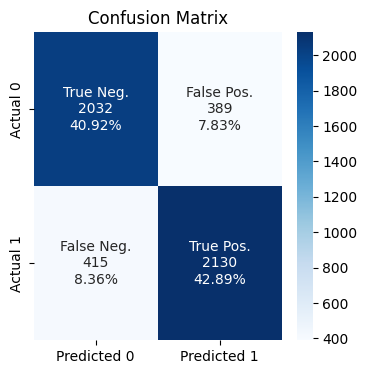

In [8]:
from backend.utils.visualizing_service import plot_confusion_matrix
plot_confusion_matrix(y_test, y_pred)

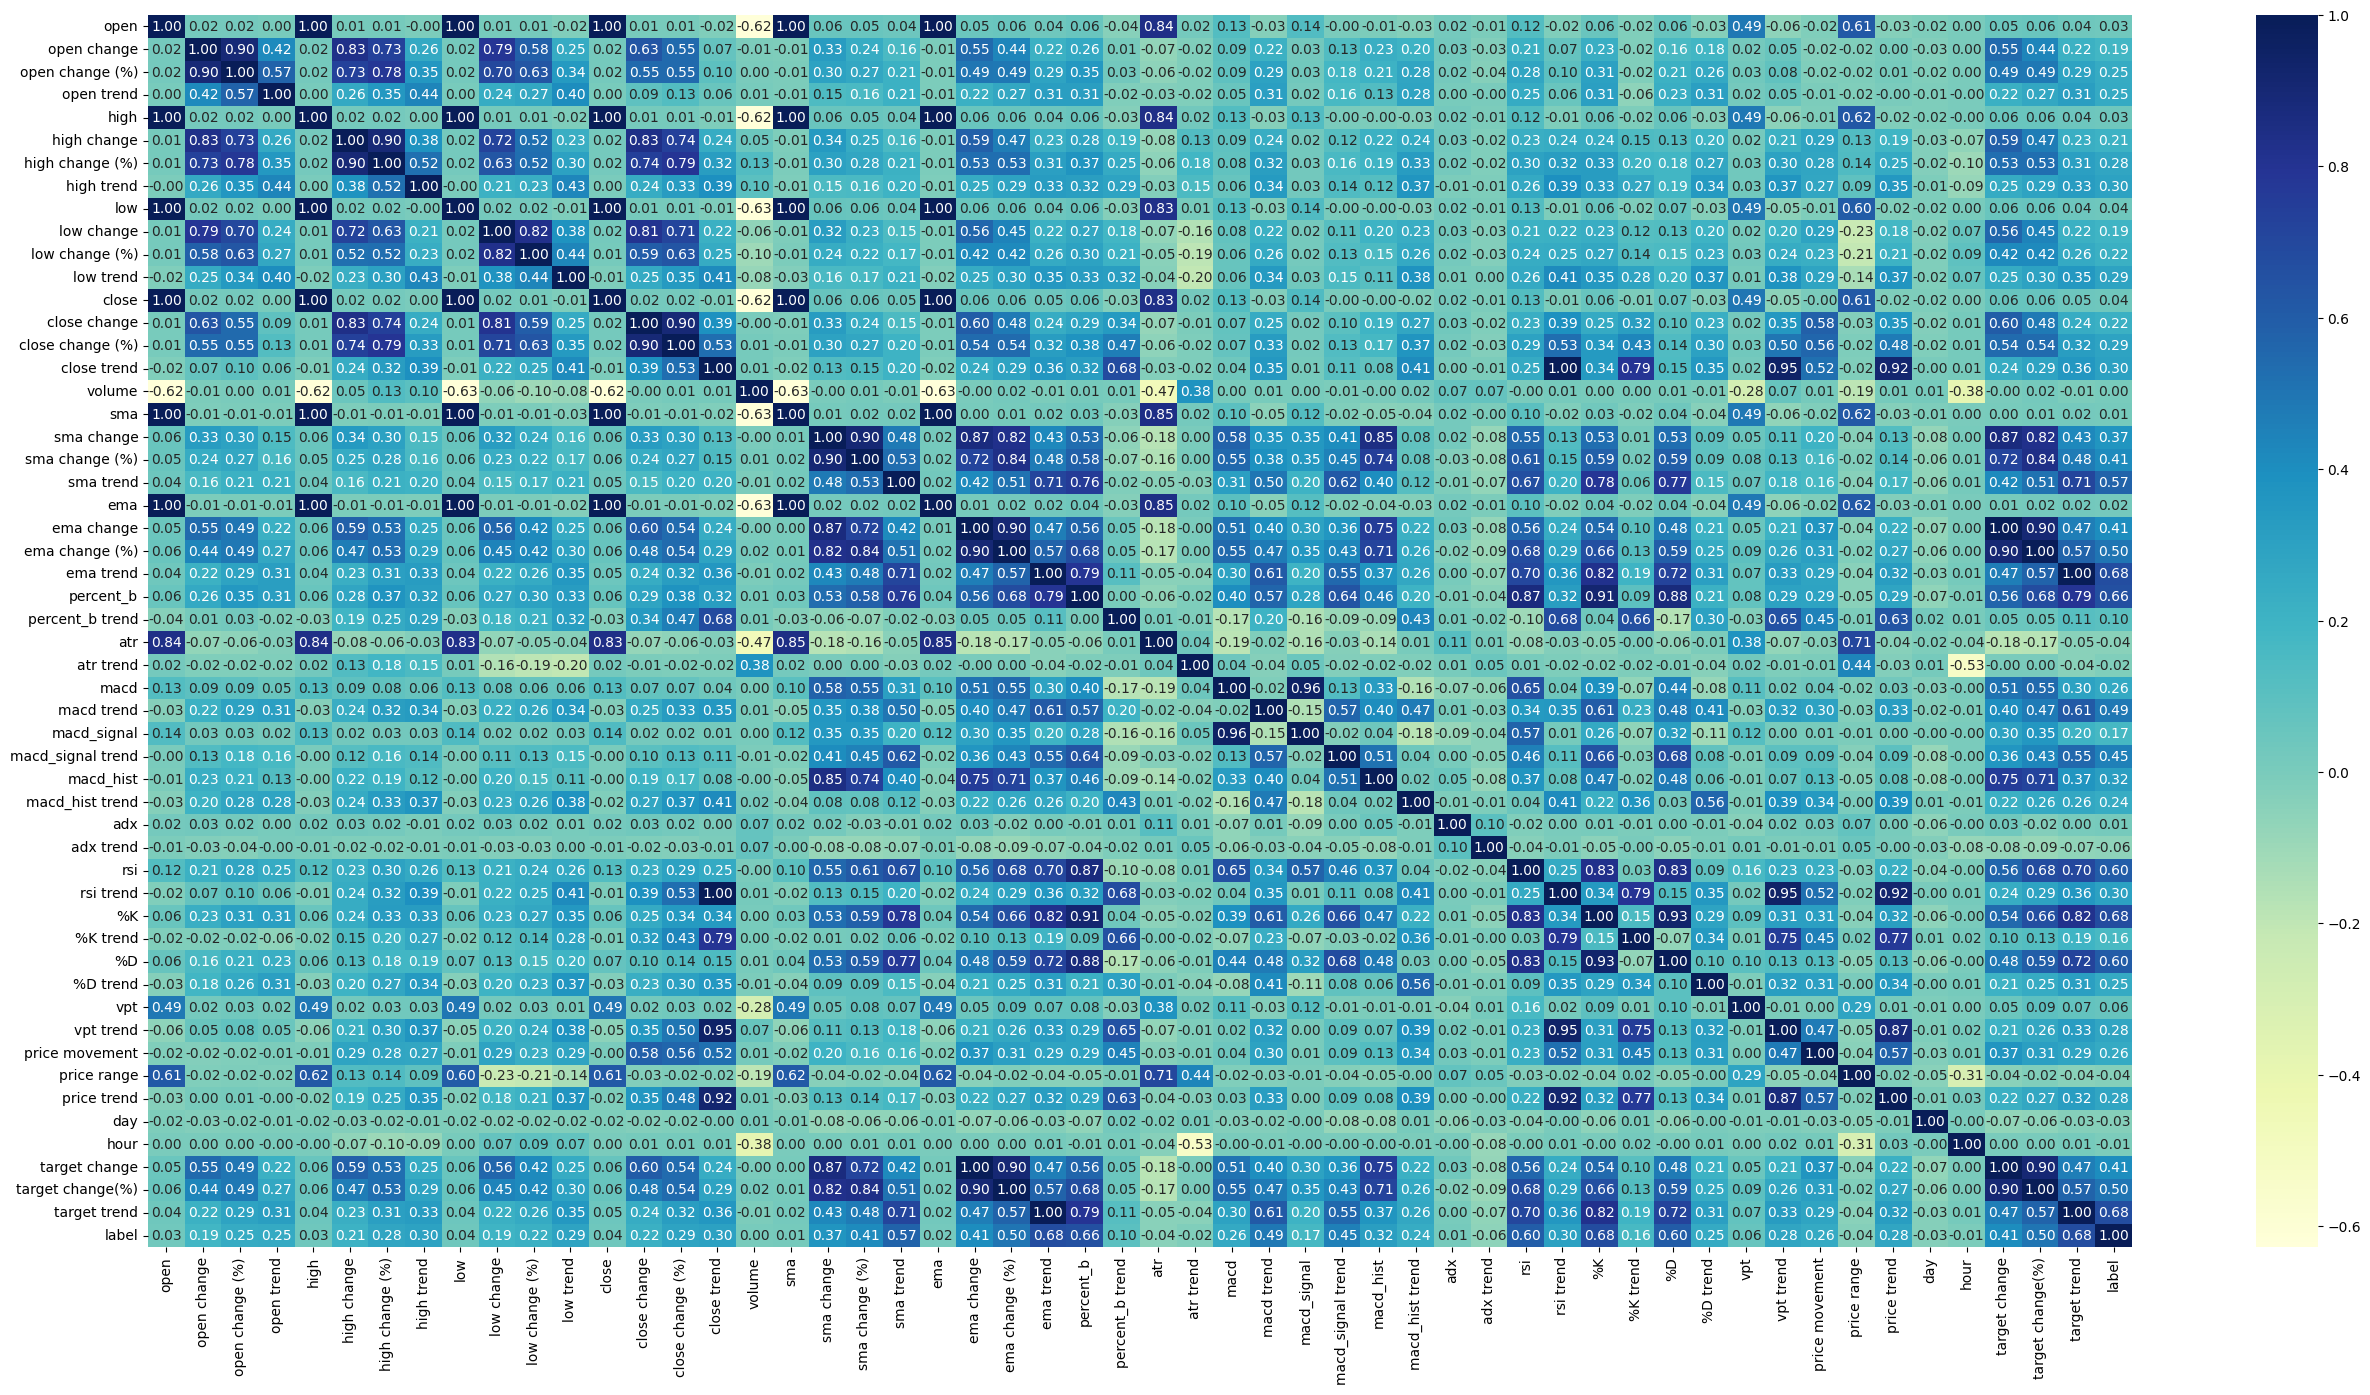

In [9]:
from backend.utils.visualizing_service import plot_correlation_heatmap
plot_correlation_heatmap(testing_preprocessor.target_data)
